# **Set up the environment**

In [ ]:
import os
import pickle
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import random
from tables import *  # needed to read .h5 files
import math
from scipy import ndimage
from tensorflow import keras

from keras.models import Sequential, Model, load_model
from keras.layers import (Dense, Dropout, Activation, Flatten,
                          concatenate, Conv3D, MaxPooling3D, Input,
                          BatchNormalization, UpSampling3D, Reshape, Average)

from keras import backend as K
from keras import optimizers

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from datetime import datetime
from keras.callbacks import TensorBoard
from keras.utils import plot_model
from keras.regularizers import l2
import tensorflow as tf
import datetime
import pandas as pd
import random

from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, auc, roc_curve
import seaborn as sn

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Neuroengineering

/content/gdrive/MyDrive/Neuroengineering


In [ ]:
root = os.getcwd()

Import python files

In [ ]:
from graphs import *

# **Load dataset**

In [ ]:
h5file = open_file("/content/gdrive/MyDrive/Neuroengineering/Dataset.h5",mode="r")

In [ ]:
y = np.array(h5file.root.target)

## Plotting the distributions of the two classes

In [ ]:
class_zero = len(np.where(y == 0)[0])
class_one = len(np.where(y == 1)[0])
print(('The number of FP is equal to: {}').format(str(class_zero)))
print(('The number of TP is equal to: {}').format(str(class_one)))

The number of FP is equal to: 6082
The number of TP is equal to: 1079


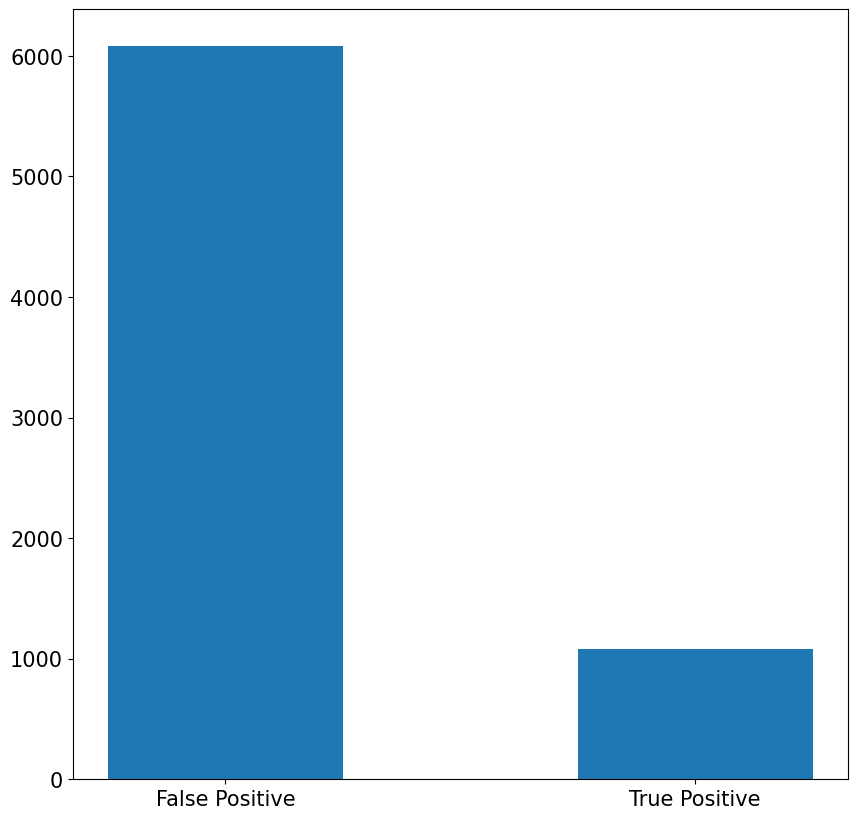

In [ ]:
names = ['False Positive', 'True Positive']
values = [class_zero, class_one]
plot_distribution_classes(values,names,[1, 1.5],title = None,show_fig=True, file_path="images/graphs/distribution.png")

## Visualization of image patches

In [ ]:
IDX_class_zero = np.where(y == 0)[0]
IDX_class_one = np.where(y == 1)[0]

In [ ]:
def normalize(x_img):
    MIN_BOUND = -1200.0
    MAX_BOUND = 600.0
    PIXEL_MEAN = 0.12  # 0.25
    PIXEL_CORR = int((MAX_BOUND - MIN_BOUND) * PIXEL_MEAN)  # in this case, 350
    x_img -= PIXEL_CORR  # centering
    x_img[x_img > MAX_BOUND] = MAX_BOUND  # clipping
    x_img[x_img < MIN_BOUND] = MIN_BOUND  # scaling
    x_img = ((x_img - (MIN_BOUND)) / (MAX_BOUND - (MIN_BOUND)))

    return x_img

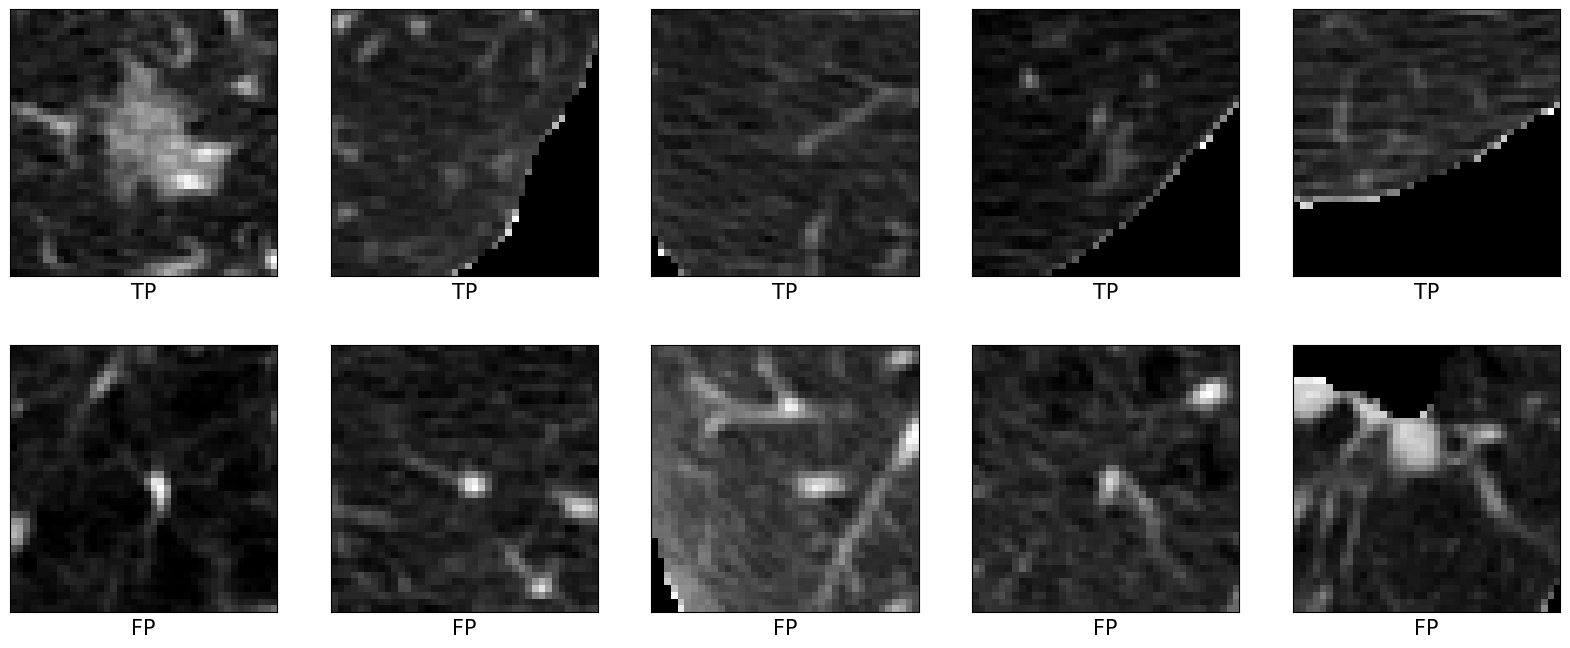

In [ ]:
plot_example_dataset(h5file,IDX_class_one,IDX_class_zero,show_fig=True, file_path=None)

## **Split the dataset**

In [ ]:
ptIDall = h5file.root.anonID[0:]
print(len(ptIDall))
ptUnique = list(set(ptIDall))

print(" The total number of patients in the dataset is equal to = {}".format(len(ptUnique)))
print(ptUnique)
random.seed(4)
random.shuffle(ptUnique)

ptIDall = h5file.root.anonID[0:]

ptUnique = list(set(ptIDall))

random.seed(4)
random.shuffle(ptUnique)

Ntr = int(len(ptUnique)*0.70)
Nval = len(ptUnique)-Ntr

ptTrain = ptUnique[0:Ntr]
ptVal = ptUnique[Ntr:]
print(" The total number of patients in the training set is equal to = {}".format(Ntr))
print(" The total number of patients in the validation set is equal to = {}".format(Nval))

idx_train = np.where(np.isin(ptIDall, ptTrain))[0]
idx_val = np.where(np.isin(ptIDall, ptVal))[0]

7161
 The total number of patients in the dataset is equal to = 81
[5125, 4103, 8, 9, 11, 24, 31, 32, 35, 4651, 558, 55, 571, 1596, 3137, 578, 67, 70, 74, 77, 5197, 80, 4176, 83, 84, 3158, 599, 88, 600, 91, 1121, 4196, 614, 1129, 620, 646, 4742, 4745, 141, 1165, 3740, 180, 3257, 698, 703, 4800, 711, 726, 738, 3820, 1778, 4339, 253, 255, 2819, 3844, 261, 4361, 272, 4368, 3872, 290, 824, 4933, 854, 1379, 3946, 365, 373, 890, 384, 4487, 923, 1960, 4528, 456, 4558, 1491, 1516, 2542, 4084]
 The total number of patients in the training set is equal to = 56
 The total number of patients in the validation set is equal to = 25


In [ ]:
train_zero = len(np.where(y[idx_train] == 0)[0])
train_one = len(np.where(y[idx_train] == 1)[0])
print('N = {} samples labelled as 0 in training set'.format(
    len(np.where(y[idx_train] == 0)[0])))
print('N = {} samples labelled as 1 in training set'.format(
    len(np.where(y[idx_train] == 1)[0])))

validation_zero = len(np.where(y[idx_val] == 0)[0])
validation_one = len(np.where(y[idx_val] == 1)[0])
print('N = {} samples labelled as 0 in validation set'.format(
    len(np.where(y[idx_val] == 0)[0])))
print('N = {} samples labelled as 1 in validation set'.format(
    len(np.where(y[idx_val] == 1)[0])))

# test_zero = len(np.where(y[idx_test]==0)[0])
# test_one = len(np.where(y[idx_test]==1)[0])
# print('N = {} samples labelled as 0 in test set'.format(len(np.where(y[idx_test]==0)[0])))
# print('N = {} samples labelled as 1 in test set'.format(len(np.where(y[idx_test]==1)[0])))

print('The training set has {} samples'.format(len(idx_train)))
print('The validation set has {} samples'.format(len(idx_val)))
# print('The test set has {} samples!'.format(len(idx_test)))

percentage_training = len(idx_train)*100/len(y)
percentage_validation = len(idx_val)*100/len(y)
# percentage_test = len(idx_test)*100/len(y)

print('The training set is the {}% of the dataset samples'.format(percentage_training))
print('The validation set is the {}% of the dataset samples'.format(
    percentage_validation))
# print('The test set is the {}% of the dataset samples'.format(percentage_test))


# CREATE THE VESTOR OF TARGETS:
# If we are using a softmax function in the output layer, we need to create a two column vector where
# - the first column corresponds to the probability of being 1 while the second to the probability of being 0
y = np.transpose(np.array([y, (1-y)]))
print(('The new shape of the target vector is {}').format(np.shape(y)))

N = 3727 samples labelled as 0 in training set
N = 737 samples labelled as 1 in training set
N = 2355 samples labelled as 0 in validation set
N = 342 samples labelled as 1 in validation set
The training set has 4464 samples
The validation set has 2697 samples
The training set is the 62.33766233766234% of the dataset samples
The validation set is the 37.66233766233766% of the dataset samples
The new shape of the target vector is (7161, 2)


The index correspond to:
* **0 = FP**
* **1 = TP**

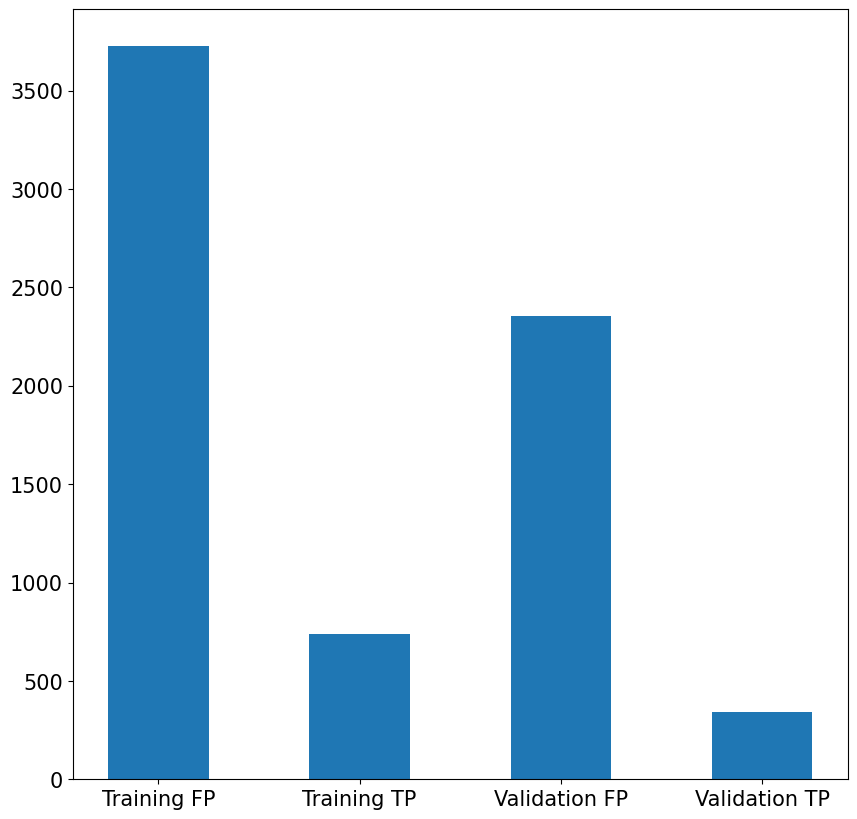

In [ ]:
names = ['Training FP', 'Training TP', 'Validation FP', 'Validation TP']
values = [train_zero, train_one, validation_zero, validation_one]

plot_distribution_classes(values,names,[1, 1.5, 2, 2.5],title = None,show_fig=True, file_path=None)

# **Full Model**


### Model definition

In [ ]:
l2_lambda = 0.03

In [ ]:
############ input layers #####################################
input_layer_AR1 = keras.layers.Input(shape=(6, 20, 20, 1))
input_layer_AR2 = keras.layers.Input(shape=(10, 30, 30, 1))
input_layer_AR3 = keras.layers.Input(shape=(26, 40, 40, 1))

############ AR1 layers #####################################
C1_AR1 = Conv3D(filters=32,
                kernel_size=(5,5,5),
                padding="same",
                activation="relu",
                kernel_regularizer=l2(l2_lambda))(input_layer_AR1)

B1_AR1 = BatchNormalization()(C1_AR1)

M1_AR1 = MaxPooling3D(pool_size =(1,1,1))(B1_AR1)

C2_AR1 = Conv3D(filters=64,
                kernel_size=(3, 3, 3),
                padding="same",
                activation="relu",
                kernel_regularizer=l2(l2_lambda))(M1_AR1)

B2_AR1 = BatchNormalization()(C2_AR1)

C3_AR1 = Conv3D(filters=128,
                kernel_size=(3, 3, 3),
                padding="same",
                activation="relu",
                kernel_regularizer=l2(l2_lambda))(C2_AR1)

B3_AR1 = BatchNormalization()(C3_AR1)

flatten_layer_AR1 = Flatten()(B3_AR1)

D1_AR1 = Dense(units = 150, activation = "relu",kernel_regularizer=l2(l2_lambda))(flatten_layer_AR1)

B4_AR1 = BatchNormalization()(D1_AR1)

DO_AR1 = Dropout(0.2)(B4_AR1)

output_layer_AR1 = keras.layers.Dense(2, activation="softmax")(DO_AR1)

############ AR2 layers #####################################

C1_AR2 = Conv3D(filters=32,
                kernel_size=(5, 5, 5),
                padding="same",
                activation="relu",kernel_regularizer=l2(l2_lambda))(input_layer_AR2)

B1_AR2 = BatchNormalization()(C1_AR2)

M1_AR2 = MaxPooling3D(pool_size =(2,2,2))(C1_AR2)

C2_AR2 = Conv3D(filters=64,
                kernel_size=(5, 5, 5),
                padding="same",
                activation="relu",kernel_regularizer=l2(l2_lambda))(M1_AR2)

B2_AR2 = BatchNormalization()(C2_AR2)

C3_AR2 = Conv3D(filters=128,
                kernel_size=(5, 5, 5),
                padding="same",
                activation="relu",kernel_regularizer=l2(l2_lambda))(C2_AR2)

B3_AR2 = BatchNormalization()(C3_AR2)

flatten_layer_AR2 = Flatten()(C3_AR2)

D1_AR2 = Dense(units = 250,activation = "relu",kernel_regularizer=l2(l2_lambda))(flatten_layer_AR2)

B4_AR2 = BatchNormalization()(D1_AR2)

DO_AR2 = Dropout(0.2)(B4_AR2)

output_layer_AR2 = keras.layers.Dense(2, activation="softmax")(DO_AR2)



############ AR3 layers #####################################


C1_AR3 = Conv3D(filters=32,
                kernel_size=(5, 5, 5),
                padding="same",
                activation="relu",kernel_regularizer=l2(l2_lambda))(input_layer_AR3)

B1_AR3 = BatchNormalization()(C1_AR3)

M1_AR3 = MaxPooling3D(pool_size =(2,2,2))(C1_AR3)

C2_AR3 = Conv3D(filters=64,
                kernel_size=(5, 5, 5),
                padding="same",
                activation="relu",kernel_regularizer=l2(l2_lambda))(M1_AR3)

B2_AR3 = BatchNormalization()(C2_AR3)

C3_AR3 = Conv3D(filters=128,
                kernel_size=(5, 5, 5),
                padding="same",
                activation="relu",kernel_regularizer=l2(l2_lambda))(C2_AR3)

B3_AR3 = BatchNormalization()(C3_AR3)

flatten_layer_AR3 = Flatten()(C3_AR3)

D1_AR3 = Dense(units = 250,activation = "relu",kernel_regularizer=l2(l2_lambda))(flatten_layer_AR3)

B4_AR3 = BatchNormalization()(D1_AR3)

DO_AR3 = Dropout(0.2)(B4_AR3)

output_layer_AR3 = keras.layers.Dense(2, activation="softmax")(D1_AR3)

############ output layer #####################################

output_layer = Average()([output_layer_AR1,output_layer_AR2,output_layer_AR3])

model_full = keras.Model(inputs=[input_layer_AR1, input_layer_AR2,input_layer_AR3],
                    outputs=output_layer,
                    name="multi_branch_model")

## Data generator definition

Dataset generation

In [ ]:
idx_trainNEWRE = np.empty((np.shape(idx_train)[0],), dtype=int)
for i in range(len(idx_train)):
    idx_trainNEWRE[i] = int(idx_train[i])

# Indexes of FP samples
idx_train_FP = idx_trainNEWRE[np.where(y[idx_trainNEWRE, 0] == 0)[0]]
# Indexes of TP samples
idx_train_TP = idx_trainNEWRE[np.where(y[idx_trainNEWRE, 0] == 1)[0]]

Data Augmentation : In the following example, we augment only the minority class

In [ ]:
# How many times we want to replicate the minority class:
Naugment_TP = 2
# concatenate the indexes of the training samples for a number of times equal to Naugment_TP
idx_train_TP_augmented = idx_train_TP
count = Naugment_TP
while count > 0:
    count = count - 1
    idx_train_TP_augmented = np.concatenate(
        (idx_train_TP_augmented, idx_train_TP), axis=0)
print(idx_train_TP_augmented.shape)

(2211,)


In [ ]:
# Possible transformations
# - 0 : original image
# - 1 : horizontal flip
# - 2 : vertical flip
# - >2 : rotation of xx degree
angles_list = [0, 1, 2, 30, 90, 150, 180, 210, 270, 330]

# Create the vectors describing the tranformation to apply to each sample
angles_FP = np.zeros((len(idx_train_FP)))
angles_TP = np.random.choice(angles_list, idx_train_TP_augmented.shape)

In [ ]:
print(len(idx_train_FP), len(idx_train_TP))
print(len(idx_train_FP), len(idx_train_TP_augmented))

3727 737
3727 2211


In [ ]:
# Merge indexes and transformation vectors of the two classes
idx_trainNEWRE = np.concatenate((idx_train_FP, idx_train_TP_augmented), axis=0)
angles_array = np.concatenate((angles_FP, angles_TP), axis=0)
# concatenate vector of indexes and of transformation
idx_angles_training = np.asarray(np.concatenate((np.expand_dims(idx_trainNEWRE, axis=1),
                                                 np.expand_dims(angles_array, axis=1)), axis=1), dtype=int)
print(idx_angles_training.shape)

(5938, 2)


In [ ]:
def imageLoader_full(files, idx_samples, target, batch_size, dim_IM_AR1, dim_IM_AR2,dim_IM_AR3):
    L = len(idx_samples)
    # random.shuffle(idx_samples)

    print(idx_samples.shape)
    idx_samples = K.print_tensor(idx_samples)
    np.random.shuffle(idx_samples)

    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_end <= L:
            limit = min(batch_end, L)

            tmpB_AR1 = np.empty(
                (limit-batch_start, dim_IM_AR1[0], dim_IM_AR1[1], dim_IM_AR1[2]))

            # WE HAVE TO ALLOCATE MEMORY FOR THE SECOND INPUT
            tmpB_AR2 = np.empty(
                (limit-batch_start, dim_IM_AR2[0], dim_IM_AR2[1], dim_IM_AR2[2]))

            tmpB_AR3 = np.empty(
                (limit-batch_start, dim_IM_AR3[0], dim_IM_AR3[1], dim_IM_AR3[2]))


            idx = -1
            for i in range(batch_start, limit):
                idx = idx+1

                img_0_1 = np.expand_dims(
                    files.root.images[idx_samples[i, 0], 10:16, 10:30, 10:30], axis=0)

                img_0_2 = np.expand_dims(
                    files.root.images[idx_samples[i, 0], 8:18, 5:35, 5:35], axis=0)

                img_0_3 = np.expand_dims(
                    files.root.images[idx_samples[i, 0], 0:26, 0:40, 0:40], axis=0)

                # image processing
                img_0_1 = normalize(img_0_1)
                img_0_2 = normalize(img_0_2)
                img_0_3 = normalize(img_0_3)

                # from the value in the second column verify which transformation apply

                angle = idx_samples[i, 1]
                if angle == 1:

                    img_1 = np.flip(img_0_1, axis=3)  # horizontal FLIP
                    img_2 = np.flip(img_0_2, axis=3)  # horizontal FLIP
                    img_3 = np.flip(img_0_3, axis=3)  # horizontal FLIP

                elif angle == 2:

                    img_1 = np.flip(img_0_1, axis=2)  # vertical FLIP
                    img_2 = np.flip(img_0_2, axis=2)  # vertical FLIP
                    img_3 = np.flip(img_0_3, axis=2)  # vertical FLIP

                elif angle > 2:

                    img_1 = ndimage.rotate(
                        img_0_1, angle, reshape=False, mode='constant', axes=(2, 3))
                    img_2 = ndimage.rotate(
                        img_0_2, angle, reshape=False, mode='constant', axes=(2, 3))
                    img_3 = ndimage.rotate(
                        img_0_3, angle, reshape=False, mode='constant', axes=(2, 3))


                elif angle == 0:  # original image is considered

                    img_1 = img_0_1
                    img_2 = img_0_2
                    img_3 = img_0_3


                # fill the allocated vector with the tranformed image
                tmpB_AR1[idx, :, :, :] = img_1
                tmpB_AR2[idx, :, :, :] = img_2
                tmpB_AR3[idx, :, :, :] = img_3

            X_AR1 = np.expand_dims(tmpB_AR1, axis=-1)
            X_AR2 = np.expand_dims(tmpB_AR2, axis=-1)
            X_AR3 = np.expand_dims(tmpB_AR3, axis=-1)

            Y = target[idx_samples[batch_start:limit, 0], :]

            # a tuple with two numpy arrays with batch_size samples
            yield ([X_AR1, X_AR2, X_AR3], Y)

            batch_start += batch_size
            batch_end += batch_size

In [ ]:
dim_IM_AR1 = (6,20,20)
dim_IM_AR2 = (10,30,30)
dim_IM_AR3 = (26,40,40)
# SET BATCH SIZE
batch_size = 64
# steps per epoch depend on the batch size
steps = len(idx_trainNEWRE)//batch_size
print(steps)
training_generator = imageLoader_full(
    h5file, idx_angles_training, y, batch_size, dim_IM_AR1, dim_IM_AR2,dim_IM_AR3)

92


In [ ]:
val_images_AR1 = np.expand_dims(
    h5file.root.images[list(idx_val), 10:16, 10:30, 10:30], axis=-1)

val_images_AR2 = np.expand_dims(
    h5file.root.images[list(idx_val), 8:18, 5:35, 5:35], axis=-1)

val_images_AR3 = np.expand_dims(
    h5file.root.images[list(idx_val), 0:26, 0:40, 0:40], axis=-1)


val_images_AR1 = normalize(val_images_AR1)

val_images_AR2 = normalize(val_images_AR2)

val_images_AR3 = normalize(val_images_AR3)

val_labels = y[list(idx_val)]

## Model compiling

### Custom Loss and Metrics

In [ ]:
bce = tf.keras.losses.BinaryCrossentropy(
    reduction=tf.keras.losses.Reduction.SUM)


def custom_crossentropy(bce):
    def loss(y_true, y_pred):
        # weights = y_true[:,2]
        y_true = y_true[:, 0:2]
        # weighted_loss = bce(y_true, y_pred, weights)
        unweighted_loss = bce(y_true, y_pred)
        return unweighted_loss

    return loss

In [ ]:
def recall(y_true, y_pred):
    y_true = y_true[:, 0:2]
    y_true = y_true[:, 0]
    y_pred = y_pred[:, 0]
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_v = true_positives / (possible_positives + K.epsilon())
    return recall_v


def precision(y_true, y_pred):
    y_true = y_true[:, 0:2]
    y_true = y_true[:, 0]
    y_pred = y_pred[:, 0]
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_v = true_positives / (predicted_positives + K.epsilon())
    return precision_v


def f1score(y_true, y_pred):
    precision_v = precision(y_true, y_pred)
    recall_v = recall(y_true, y_pred)
    return 2*((precision_v*recall_v)/(precision_v+recall_v+K.epsilon()))

### Compiling

In [ ]:
adam_full = keras.optimizers.AdamW(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model_full.compile(
    loss=custom_crossentropy(bce),
    optimizer=adam_full,
    metrics=['acc', f1score, precision, recall]
)


## Model training

In [ ]:
earlystop_patience = 10
earlystopper = EarlyStopping(patience=earlystop_patience, verbose=1,monitor="val_f1score",mode="max",restore_best_weights=True,start_from_epoch=5)

In [ ]:
CALLBACKS_FOLDER_full = os.path.join(root, 'ARCH_full_no_res')
os.makedirs(CALLBACKS_FOLDER_full, exist_ok=True)

In [ ]:
checkpointer_val_f1score_full = ModelCheckpoint(filepath=CALLBACKS_FOLDER_full + "/best_max_val_f1score_no_res.h5",
                                               monitor='val_f1score',
                                               verbose=1,
                                               save_best_only=True,
                                               mode='max',
                                               period=1)

In [ ]:
history_full = model_full.fit(x=training_generator,
                     validation_data=(
                         [val_images_AR1, val_images_AR2,val_images_AR3], val_labels),
                     epochs=100, steps_per_epoch=steps,
                     callbacks=[checkpointer_val_f1score_full,earlystopper]
                     )

## Results

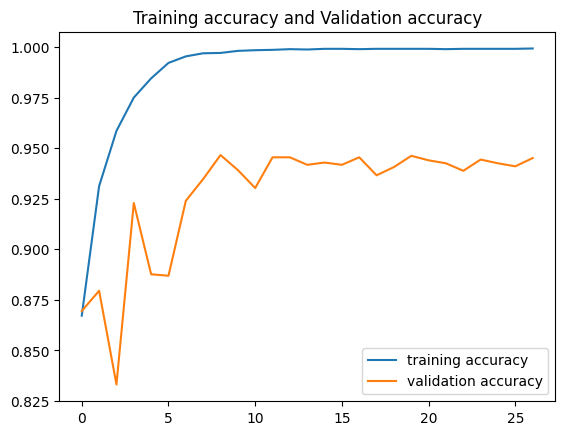

In [ ]:
plot_acc_train_val(history_full,title='Training accuracy and Validation accuracy',show_fig=True, file_path=None)

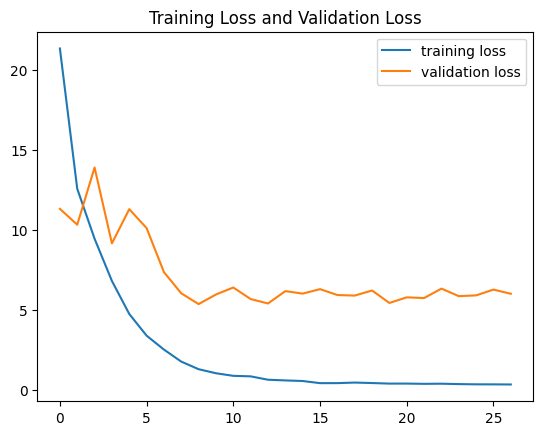

In [ ]:
plot_loss_train_val(history_full)

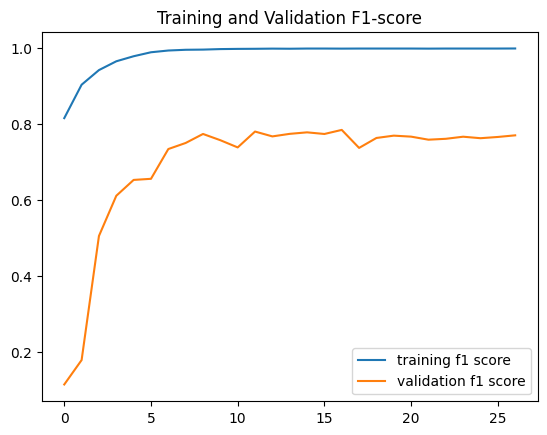

In [ ]:
plot_f1_train_val(history_full)

In [ ]:
from sklearn.metrics import classification_report

y_pred_val = archfull_restored.predict([val_images_AR1, val_images_AR2,val_images_AR3])

y_pred_val = np.argmax(y_pred_val, axis=1)
y_true = np.argmax(val_labels, axis=1)

print(classification_report(y_true, y_pred_val, target_names=["FP","TP"]))

85/85 [==============================] - 1209s 14s/step
              precision    recall  f1-score   support

          FP       0.76      0.88      0.82       342
          TP       0.98      0.96      0.97      2355

    accuracy                           0.95      2697
   macro avg       0.87      0.92      0.89      2697
weighted avg       0.95      0.95      0.95      2697



In [ ]:
from sklearn.metrics import confusion_matrix

CM = confusion_matrix(y_true, y_pred_val)
print(CM)

[[ 301   41]
 [  95 2260]]


In [ ]:
archfull_restored = load_model(
    root + "/ARCH_full_no_res/best_max_val_f1score_no_res.h5", compile=False)

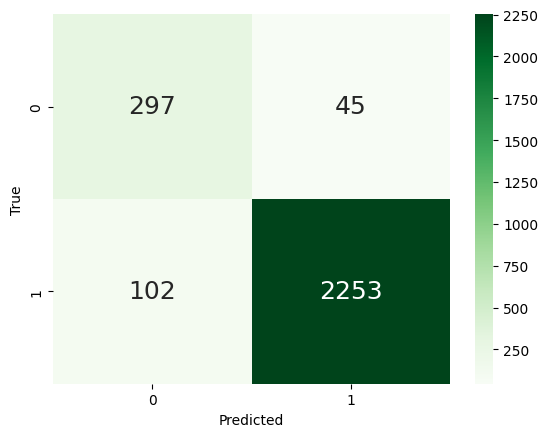

TP=1 and FP=0


In [ ]:
# Confusion Matrix
CM = confusion_matrix(y_true, y_pred_val)
fig = plt.figure()
ax = sn.heatmap(CM, annot=True, annot_kws={
                "size": 18}, fmt='g', cmap=plt.cm.Greens)  # font size
plt.xticks(color='black')
plt.yticks(color='black')
plt.xlabel("Predicted", color='black')
plt.ylabel("True", color='black')
plt.show()
print('TP=1 and FP=0')